In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import csv
from datetime import datetime

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import tqdm         # make loops show as a smart progress meter

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import os

In [ ]:
# 1) Classic_Model (ReLu,  bias, not orthogonal, Softmax)========================================================================================================
class ClassicalModel_Relu_Bias(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[8, 8], output_size=3):
        """
        input_size: number of input features (e.g. 4 for Iris)
        hidden_sizes: list of hidden layer sizes, e.g. [8, 8, 4]
        output_size: number of output classes (e.g. 3 for Iris)
        """
        super(ClassicalModel, self).__init__()
        
        # Create a list of layer sizes
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        # Create a list of Linear layers
        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1])
            for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, x):
        # Go through all layers except the last one with ReLU
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        # Apply softmax on the last layer (output)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [6]:
# 2) Classic_Model_NoBias (ReLU, no bias, Not orthogonal, SoftMax)============================================================================================
class ClassicalModel_ReLU_NoBias(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[8,8], output_size=3):
        """
        ReLU, no bias, standard weights, SoftMax
        """
        super(ClassicalModel_ReLU_NoBias, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=False)
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [ ]:
# 3) Classic_Model_NoRelu (No ReLu, bias, Not orthogonal, SoftMax)========================================================================================================
class ClassicalModel_NoRelu_Bias(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[8, 8], output_size=3):
        """
        input_size: number of input features (e.g. 4 for Iris)
        hidden_sizes: list of hidden layer sizes, e.g. [8, 8, 4]
        output_size: number of output classes (e.g. 3 for Iris)
        """
        super(LinearVariableModel_NoRelu, self).__init__()
        
        # Create a list of layer sizes
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        # Create a list of Linear layers
        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, x): #defines how an input x becomes an output, passing through the network’s layers.
        # Go through all layers except the last one with ReLU
        for layer in self.layers[:-1]:
            x = layer(x)
        # Apply softmax on the last layer (output)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [8]:
# 4) Classic_Model_NoReLU_NoBias (No ReLU, no bias, Not orthogonal, SoftMax)===============================================================================
class ClassicalModel_NoReLU_NoBias(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[8,8], output_size=3):
        """
        input_size: number of input features (e.g. 4 for Iris)
        hidden_sizes: list of hidden layer sizes, e.g. [8, 8, 4]
        output_size: number of output classes (e.g. 3 for Iris)
        """
        super(ClassicalModel_NoReLU_NoBias, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=False)
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [9]:
# 5) Classic_Model_Ortho_ReLU_Bias (ReLU, bias, orthogonal, SoftMax)======================================================================================
class ClassicalModel_Ortho_ReLU_Bias(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[8,8], output_size=3):
        """
        ReLU, bias, orthogonal weights, SoftMax
        """
        super(ClassicalModel_Ortho_ReLU_Bias, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [10]:
# 6) Classic_Model_Ortho_ReLU_NoBias (ReLU, no bias, orthogonal, SoftMax)================================================================================
class ClassicalModel_Ortho_ReLU_NoBias(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[8,8], output_size=3):
        """
        ReLU, no bias, orthogonal weights, SoftMax
        """
        super(ClassicalModel_Ortho_ReLU_NoBias, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=False))
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [11]:
# 7) Classic_Model_Ortho_NoReLU_Bias (No ReLU, bias, orthogonal, SoftMax)===============================================================================
class ClassicalModel_Ortho_NoReLU_Bias(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[8,8], output_size=3):
        """
        No ReLU, bias, orthogonal weights, SoftMax
        """
        super(ClassicalModel_Ortho_NoReLU_Bias, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [12]:

# 8) Classic_Model_Ortho_NoReLU_NoBias (No ReLU, no bias, orthogonal, SoftMax)=========================================================================
class ClassicalModel_Ortho_NoReLU_NoBias(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[8,8], output_size=3):
        """
        No ReLU, no bias, orthogonal weights, SoftMax
        """
        super(ClassicalModel_Ortho_NoReLU_NoBias, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=False))
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [13]:
# Real_Photonic_Model (Ortho, ReLu, SoftMax and bias)========================================================================================================
# Variable is added to the name because layers and neurons can now be chosen
class RealVariableModel(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[8, 8], output_size=3):
        """
        input_size: number of input features (e.g. 4 for Iris)
        hidden_sizes: list of hidden layer sizes, e.g. [8, 8, 4]
        output_size: number of output classes (e.g. 3 for Iris)
        """
        super(RealVariableModel, self).__init__()
        
        # Create a list of layer sizes
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        # Create a list of Linear layers
        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, I_input):
        E = torch.sqrt(I_input).to(torch.complex64)
        # Go through all layers except the last one with ReLU
        for layer in self.layers[:-1]:
            E = F.relu(layer(E))
        # Apply softmax on the last layer (output)
        E = self.layers[-1](E)
        I_out = torch.real(E * E.conj())
        return F.softmax(I_out, dim=1)

In [14]:
class train_backprop():

    def __init__(self) -> None:
        iris = load_iris()
        X = iris['data']
        y = torch.tensor(iris['target'], dtype=torch.long)

        scaler = StandardScaler()
        X_scaled = torch.tensor(scaler.fit_transform(X), dtype=torch.float)

        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=2)  # Total n dat 150, so 120 for train and 30 for test

        self.train_data = TensorDataset(X_train, y_train)
        test_data = TensorDataset(X_test, y_test)

        self.train_loader = DataLoader(self.train_data, shuffle=True, batch_size=12)  # batch size 12 so 10 batch
        self.test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))  # batch size 30 max

    def train_IRIS(self, model, epochs: int = 400, epsilon: float = 0.02):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        train_loss = np.zeros(epochs)
        valid_loss = np.zeros(epochs)
        train_accuracy = np.zeros(epochs)
        valid_accuracy = np.zeros(epochs)

        for epoch in tqdm.trange(epochs):
            # --- Train ---
            for X, y in self.train_loader:
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # --- Training metrics ---
            with torch.no_grad():
                X_train, y_train = self.train_data[:]
                y_pred_train = model(X_train)
                train_loss[epoch] = loss_fn(y_pred_train, y_train).item()
                y_pred_labels = torch.argmax(y_pred_train, axis=1)
                train_accuracy[epoch] = torch.mean((y_pred_labels == y_train).float()).item()

            # --- Validation metrics ---
            with torch.no_grad():
                X_val, y_val = next(iter(self.test_loader))
                y_pred_val = model(X_val)
                valid_loss[epoch] = loss_fn(y_pred_val, y_val).item()
                y_pred_labels = torch.argmax(y_pred_val, axis=1)
                valid_accuracy[epoch] = torch.mean((y_pred_labels == y_val).float()).item()

        # --- Final loss ---
        final_train_loss = train_loss[-1]
        final_valid_loss = valid_loss[-1]

        # --- Epochs to reach within epsilon of final loss ---
        epochs_to_final_train = np.argmax(train_loss <= final_train_loss * (1 + epsilon)) + 1
        epochs_to_final_valid = np.argmax(valid_loss <= final_valid_loss * (1 + epsilon)) + 1

        return train_loss, valid_loss, train_accuracy, valid_accuracy, epochs_to_final_train, epochs_to_final_valid

        

    def graph_train_IRIS(self, model, epochs: int = 400, n_runs: int = 15, epsilon: float = 0.02) -> None:
        """
        Train the given model multiple times (n_runs) and save all results in a single CSV file.
        The CSV includes model name, hidden layer configuration, final metrics, and epochs to convergence.
        Only the final run displays the training graph.
        """
        import os
        from datetime import datetime
        import pandas as pd
        import matplotlib.pyplot as plt

        os.makedirs("results", exist_ok=True)

        model_name = model.__class__.__name__

        # Detect hidden layer sizes if possible
        try:
            hidden_sizes = [layer.out_features for layer in model.layers[:-1]]
        except AttributeError:
            hidden_sizes = ["Unknown"]

        # Use timestamp of the first run for filename
        global_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        all_runs = []  # store all runs here

        for run in range(1, n_runs + 1):
            model_instance = model.__class__()  # re-instantiate model for each run
            print(f"🚀 Run {run}/{n_runs} for {model_name} with layers {hidden_sizes}")

            # Call updated train_IRIS which returns epochs_to_final_train/valid
            train_loss, valid_loss, train_accuracy, valid_accuracy, epochs_to_final_train, epochs_to_final_valid = self.train_IRIS(model_instance, epochs, epsilon)

            final_train_loss = train_loss[-1]
            final_valid_loss = valid_loss[-1]
            final_train_acc = train_accuracy[-1]
            final_valid_acc = valid_accuracy[-1]

            all_runs.append({
                "timestamp": global_timestamp,
                "model_name": model_name,
                "hidden_sizes": str(hidden_sizes),
                "epochs": epochs,
                "run_number": run,
                "final_train_loss": final_train_loss,
                "final_valid_loss": final_valid_loss,
                "final_train_accuracy": final_train_acc,
                "final_valid_accuracy": final_valid_acc,
                "epochs_to_final_train": epochs_to_final_train,
                "epochs_to_final_valid": epochs_to_final_valid
            })

            print(f"🏁 Validation accuracy (run {run}): {final_valid_acc:.3f}")
            print(f"⏱️ Epochs to converge (train/valid) ≈ {epochs_to_final_train}/{epochs_to_final_valid}")

            # Show the training curves only for the last run
            if run == n_runs:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
                ax1.plot(train_accuracy, label="Train accuracy")
                ax1.plot(valid_accuracy, label="Validation accuracy")
                ax1.set_title("Accuracy")
                ax1.set_xlabel("epochs")
                ax1.set_ylim([0.0, 1.05])
                ax1.legend()

                ax2.plot(train_loss, label="Train loss")
                ax2.plot(valid_loss, label="Validation loss")
                ax2.set_title("Loss")
                ax2.set_xlabel("epochs")
                ax2.legend()
                plt.show()

        # Save all results after all runs
        results_df = pd.DataFrame(all_runs)
        csv_filename = f"{model_name}_layers{hidden_sizes}_epochs{epochs}_{n_runs}runs_{global_timestamp}.csv"
        csv_path = os.path.join("results", csv_filename)
        results_df.to_csv(csv_path, index=False)

        print(f"\n✅ All {n_runs} runs saved in one file → {csv_path}")



🚀 Run 1/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:05<00:00, 75.14it/s]


🏁 Validation accuracy (run 1): 0.933
⏱️ Epochs to converge (train/valid) ≈ 188/180
🚀 Run 2/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:05<00:00, 71.38it/s]


🏁 Validation accuracy (run 2): 0.933
⏱️ Epochs to converge (train/valid) ≈ 130/166
🚀 Run 3/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:05<00:00, 74.70it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 156/93
🚀 Run 4/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:05<00:00, 72.24it/s]


🏁 Validation accuracy (run 4): 0.967
⏱️ Epochs to converge (train/valid) ≈ 152/106
🚀 Run 5/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:06<00:00, 58.03it/s]


🏁 Validation accuracy (run 5): 0.967
⏱️ Epochs to converge (train/valid) ≈ 169/91
🚀 Run 6/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:07<00:00, 53.97it/s]


🏁 Validation accuracy (run 6): 0.933
⏱️ Epochs to converge (train/valid) ≈ 182/141
🚀 Run 7/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:06<00:00, 61.46it/s]


🏁 Validation accuracy (run 7): 0.967
⏱️ Epochs to converge (train/valid) ≈ 165/198
🚀 Run 8/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:06<00:00, 63.10it/s]


🏁 Validation accuracy (run 8): 0.933
⏱️ Epochs to converge (train/valid) ≈ 209/130
🚀 Run 9/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:06<00:00, 63.90it/s]


🏁 Validation accuracy (run 9): 0.967
⏱️ Epochs to converge (train/valid) ≈ 111/180
🚀 Run 10/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:07<00:00, 56.66it/s]


🏁 Validation accuracy (run 10): 0.967
⏱️ Epochs to converge (train/valid) ≈ 142/112
🚀 Run 11/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:06<00:00, 63.71it/s]


🏁 Validation accuracy (run 11): 0.967
⏱️ Epochs to converge (train/valid) ≈ 143/87
🚀 Run 12/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:06<00:00, 63.82it/s]


🏁 Validation accuracy (run 12): 0.967
⏱️ Epochs to converge (train/valid) ≈ 193/147
🚀 Run 13/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:06<00:00, 63.79it/s]


🏁 Validation accuracy (run 13): 0.933
⏱️ Epochs to converge (train/valid) ≈ 170/81
🚀 Run 14/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:06<00:00, 61.77it/s]


🏁 Validation accuracy (run 14): 0.967
⏱️ Epochs to converge (train/valid) ≈ 216/130
🚀 Run 15/15 for ClassicalModel with layers [1]


100%|██████████| 400/400 [00:06<00:00, 63.74it/s]


🏁 Validation accuracy (run 15): 0.967
⏱️ Epochs to converge (train/valid) ≈ 178/151


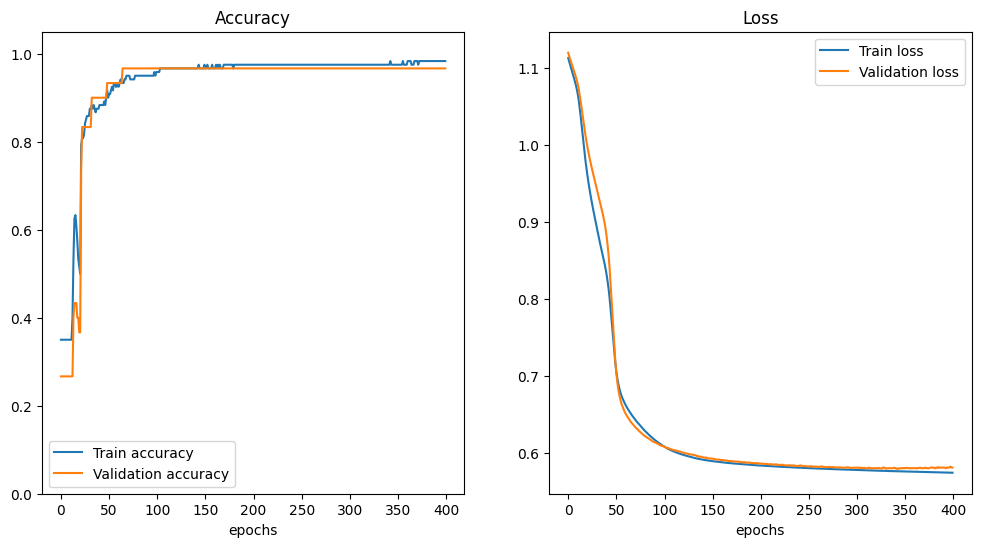


✅ All 15 runs saved in one file → results\ClassicalModel_layers[1]_epochs400_15runs_20251202_181309.csv
🚀 Run 1/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:06<00:00, 63.71it/s]


🏁 Validation accuracy (run 1): 0.933
⏱️ Epochs to converge (train/valid) ≈ 174/118
🚀 Run 2/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:06<00:00, 63.79it/s]


🏁 Validation accuracy (run 2): 0.967
⏱️ Epochs to converge (train/valid) ≈ 197/111
🚀 Run 3/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:06<00:00, 63.90it/s]


🏁 Validation accuracy (run 3): 0.933
⏱️ Epochs to converge (train/valid) ≈ 149/95
🚀 Run 4/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:06<00:00, 60.34it/s]


🏁 Validation accuracy (run 4): 0.933
⏱️ Epochs to converge (train/valid) ≈ 160/89
🚀 Run 5/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:06<00:00, 63.36it/s]


🏁 Validation accuracy (run 5): 1.000
⏱️ Epochs to converge (train/valid) ≈ 114/166
🚀 Run 6/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:08<00:00, 47.90it/s]


🏁 Validation accuracy (run 6): 0.967
⏱️ Epochs to converge (train/valid) ≈ 105/82
🚀 Run 7/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:08<00:00, 47.27it/s]


🏁 Validation accuracy (run 7): 0.967
⏱️ Epochs to converge (train/valid) ≈ 155/160
🚀 Run 8/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:07<00:00, 55.48it/s]


🏁 Validation accuracy (run 8): 0.967
⏱️ Epochs to converge (train/valid) ≈ 114/161
🚀 Run 9/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:06<00:00, 60.27it/s]


🏁 Validation accuracy (run 9): 0.967
⏱️ Epochs to converge (train/valid) ≈ 276/279
🚀 Run 10/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:07<00:00, 54.06it/s]


🏁 Validation accuracy (run 10): 1.000
⏱️ Epochs to converge (train/valid) ≈ 187/281
🚀 Run 11/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:08<00:00, 46.87it/s]


🏁 Validation accuracy (run 11): 0.933
⏱️ Epochs to converge (train/valid) ≈ 155/89
🚀 Run 12/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:08<00:00, 48.73it/s]


🏁 Validation accuracy (run 12): 0.967
⏱️ Epochs to converge (train/valid) ≈ 165/201
🚀 Run 13/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:08<00:00, 48.86it/s]


🏁 Validation accuracy (run 13): 0.967
⏱️ Epochs to converge (train/valid) ≈ 121/106
🚀 Run 14/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:08<00:00, 46.88it/s]


🏁 Validation accuracy (run 14): 0.967
⏱️ Epochs to converge (train/valid) ≈ 146/159
🚀 Run 15/15 for ClassicalModel with layers [1, 1]


100%|██████████| 400/400 [00:08<00:00, 45.88it/s]


🏁 Validation accuracy (run 15): 0.967
⏱️ Epochs to converge (train/valid) ≈ 155/97


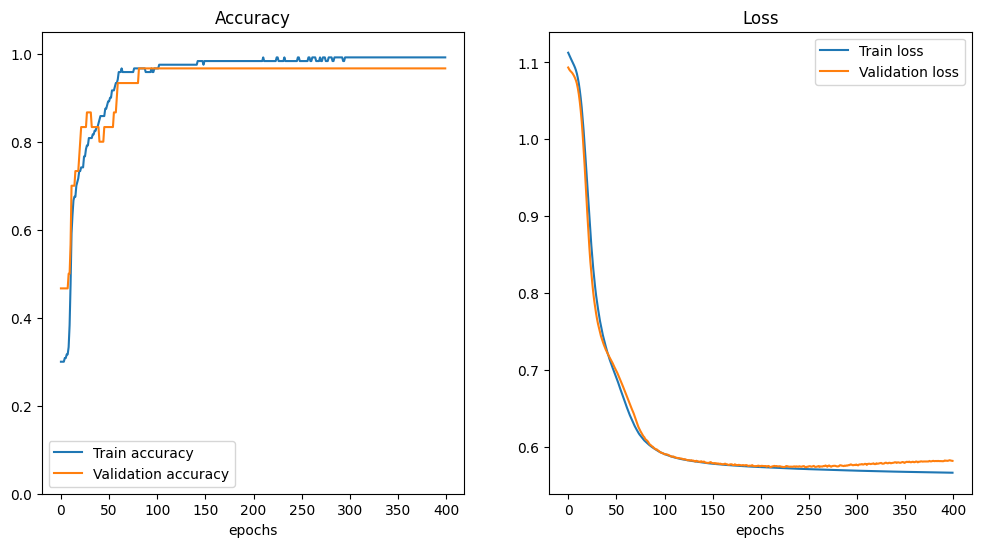


✅ All 15 runs saved in one file → results\ClassicalModel_layers[1, 1]_epochs400_15runs_20251202_181443.csv
🚀 Run 1/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:10<00:00, 38.89it/s]


🏁 Validation accuracy (run 1): 1.000
⏱️ Epochs to converge (train/valid) ≈ 127/174
🚀 Run 2/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:09<00:00, 42.48it/s]


🏁 Validation accuracy (run 2): 0.967
⏱️ Epochs to converge (train/valid) ≈ 253/213
🚀 Run 3/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:10<00:00, 38.44it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 116/141
🚀 Run 4/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:12<00:00, 32.77it/s]


🏁 Validation accuracy (run 4): 0.967
⏱️ Epochs to converge (train/valid) ≈ 177/96
🚀 Run 5/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:12<00:00, 33.23it/s]


🏁 Validation accuracy (run 5): 0.933
⏱️ Epochs to converge (train/valid) ≈ 159/76
🚀 Run 6/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:13<00:00, 30.52it/s]


🏁 Validation accuracy (run 6): 0.967
⏱️ Epochs to converge (train/valid) ≈ 208/117
🚀 Run 7/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:12<00:00, 31.87it/s]


🏁 Validation accuracy (run 7): 0.933
⏱️ Epochs to converge (train/valid) ≈ 193/103
🚀 Run 8/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:13<00:00, 29.29it/s]


🏁 Validation accuracy (run 8): 0.933
⏱️ Epochs to converge (train/valid) ≈ 166/81
🚀 Run 9/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:12<00:00, 31.21it/s]


🏁 Validation accuracy (run 9): 0.933
⏱️ Epochs to converge (train/valid) ≈ 192/150
🚀 Run 10/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:13<00:00, 29.34it/s]


🏁 Validation accuracy (run 10): 0.967
⏱️ Epochs to converge (train/valid) ≈ 149/147
🚀 Run 11/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:12<00:00, 31.75it/s]


🏁 Validation accuracy (run 11): 0.967
⏱️ Epochs to converge (train/valid) ≈ 147/80
🚀 Run 12/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:14<00:00, 28.24it/s]


🏁 Validation accuracy (run 12): 0.967
⏱️ Epochs to converge (train/valid) ≈ 168/198
🚀 Run 13/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:13<00:00, 30.49it/s]


🏁 Validation accuracy (run 13): 0.967
⏱️ Epochs to converge (train/valid) ≈ 136/114
🚀 Run 14/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:12<00:00, 32.79it/s]


🏁 Validation accuracy (run 14): 0.967
⏱️ Epochs to converge (train/valid) ≈ 174/102
🚀 Run 15/15 for ClassicalModel with layers [1, 1, 1]


100%|██████████| 400/400 [00:12<00:00, 31.16it/s]


🏁 Validation accuracy (run 15): 0.967
⏱️ Epochs to converge (train/valid) ≈ 142/184


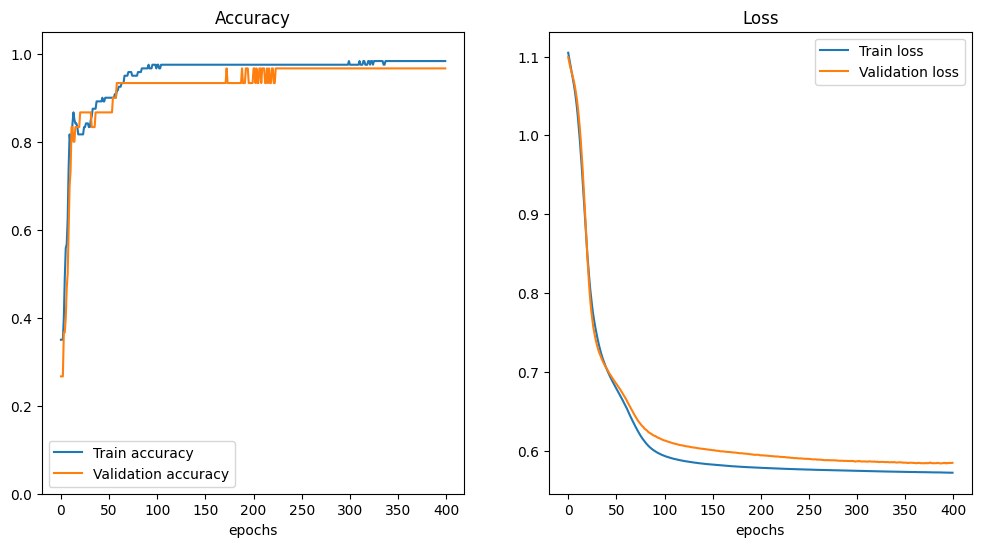


✅ All 15 runs saved in one file → results\ClassicalModel_layers[1, 1, 1]_epochs400_15runs_20251202_181636.csv
🚀 Run 1/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:12<00:00, 31.45it/s]


🏁 Validation accuracy (run 1): 1.000
⏱️ Epochs to converge (train/valid) ≈ 117/145
🚀 Run 2/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:10<00:00, 38.71it/s]


🏁 Validation accuracy (run 2): 0.967
⏱️ Epochs to converge (train/valid) ≈ 141/113
🚀 Run 3/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:09<00:00, 41.15it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 144/122
🚀 Run 4/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:10<00:00, 38.84it/s]


🏁 Validation accuracy (run 4): 0.967
⏱️ Epochs to converge (train/valid) ≈ 151/88
🚀 Run 5/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:09<00:00, 44.12it/s]


🏁 Validation accuracy (run 5): 0.933
⏱️ Epochs to converge (train/valid) ≈ 167/95
🚀 Run 6/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:09<00:00, 41.63it/s]


🏁 Validation accuracy (run 6): 0.967
⏱️ Epochs to converge (train/valid) ≈ 139/91
🚀 Run 7/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:09<00:00, 42.58it/s]


🏁 Validation accuracy (run 7): 0.933
⏱️ Epochs to converge (train/valid) ≈ 152/99
🚀 Run 8/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:09<00:00, 42.87it/s]


🏁 Validation accuracy (run 8): 0.967
⏱️ Epochs to converge (train/valid) ≈ 208/149
🚀 Run 9/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:09<00:00, 41.94it/s]


🏁 Validation accuracy (run 9): 0.933
⏱️ Epochs to converge (train/valid) ≈ 155/69
🚀 Run 10/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:10<00:00, 38.02it/s]


🏁 Validation accuracy (run 10): 1.000
⏱️ Epochs to converge (train/valid) ≈ 127/208
🚀 Run 11/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:10<00:00, 37.79it/s]


🏁 Validation accuracy (run 11): 1.000
⏱️ Epochs to converge (train/valid) ≈ 110/132
🚀 Run 12/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:09<00:00, 43.58it/s]


🏁 Validation accuracy (run 12): 0.967
⏱️ Epochs to converge (train/valid) ≈ 155/121
🚀 Run 13/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:08<00:00, 45.31it/s]


🏁 Validation accuracy (run 13): 0.933
⏱️ Epochs to converge (train/valid) ≈ 211/128
🚀 Run 14/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:08<00:00, 46.04it/s]


🏁 Validation accuracy (run 14): 0.933
⏱️ Epochs to converge (train/valid) ≈ 143/71
🚀 Run 15/15 for ClassicalModel with layers [1, 1, 1, 1]


100%|██████████| 400/400 [00:08<00:00, 47.21it/s]


🏁 Validation accuracy (run 15): 0.933
⏱️ Epochs to converge (train/valid) ≈ 180/90


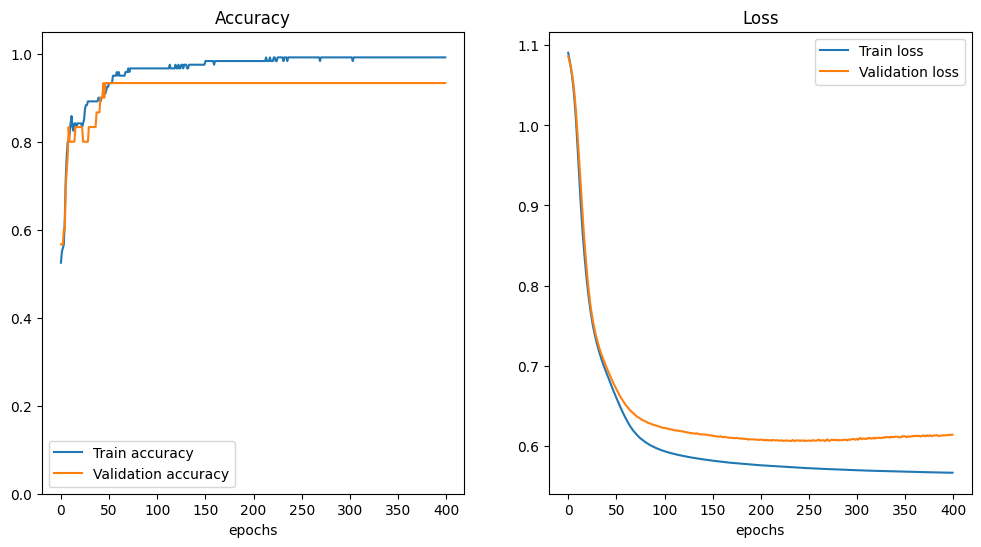


✅ All 15 runs saved in one file → results\ClassicalModel_layers[1, 1, 1, 1]_epochs400_15runs_20251202_181942.csv
🚀 Run 1/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:09<00:00, 41.86it/s]


🏁 Validation accuracy (run 1): 0.933
⏱️ Epochs to converge (train/valid) ≈ 159/99
🚀 Run 2/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:08<00:00, 44.83it/s]


🏁 Validation accuracy (run 2): 0.967
⏱️ Epochs to converge (train/valid) ≈ 140/92
🚀 Run 3/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:08<00:00, 45.12it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 151/89
🚀 Run 4/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:09<00:00, 43.46it/s]


🏁 Validation accuracy (run 4): 1.000
⏱️ Epochs to converge (train/valid) ≈ 102/132
🚀 Run 5/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:07<00:00, 54.58it/s]


🏁 Validation accuracy (run 5): 0.967
⏱️ Epochs to converge (train/valid) ≈ 114/108
🚀 Run 6/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:07<00:00, 52.74it/s]


🏁 Validation accuracy (run 6): 0.967
⏱️ Epochs to converge (train/valid) ≈ 130/70
🚀 Run 7/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:07<00:00, 51.36it/s]


🏁 Validation accuracy (run 7): 0.933
⏱️ Epochs to converge (train/valid) ≈ 159/154
🚀 Run 8/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:07<00:00, 51.10it/s]


🏁 Validation accuracy (run 8): 1.000
⏱️ Epochs to converge (train/valid) ≈ 125/197
🚀 Run 9/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:07<00:00, 51.67it/s]


🏁 Validation accuracy (run 9): 1.000
⏱️ Epochs to converge (train/valid) ≈ 109/196
🚀 Run 10/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:08<00:00, 49.76it/s]


🏁 Validation accuracy (run 10): 0.967
⏱️ Epochs to converge (train/valid) ≈ 144/147
🚀 Run 11/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:08<00:00, 49.31it/s]


🏁 Validation accuracy (run 11): 0.933
⏱️ Epochs to converge (train/valid) ≈ 151/89
🚀 Run 12/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:08<00:00, 48.28it/s]


🏁 Validation accuracy (run 12): 0.967
⏱️ Epochs to converge (train/valid) ≈ 177/128
🚀 Run 13/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:08<00:00, 49.77it/s]


🏁 Validation accuracy (run 13): 0.933
⏱️ Epochs to converge (train/valid) ≈ 289/193
🚀 Run 14/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:08<00:00, 48.03it/s]


🏁 Validation accuracy (run 14): 0.967
⏱️ Epochs to converge (train/valid) ≈ 163/141
🚀 Run 15/15 for ClassicalModel with layers [2]


100%|██████████| 400/400 [00:08<00:00, 45.38it/s]


🏁 Validation accuracy (run 15): 0.967
⏱️ Epochs to converge (train/valid) ≈ 181/108


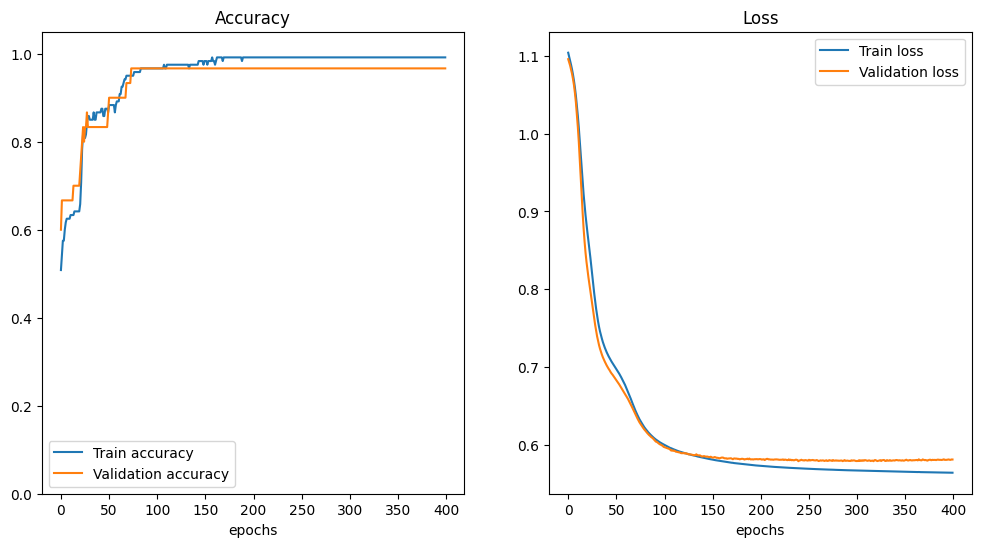


✅ All 15 runs saved in one file → results\ClassicalModel_layers[2]_epochs400_15runs_20251202_182208.csv
🚀 Run 1/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:08<00:00, 46.17it/s]


🏁 Validation accuracy (run 1): 0.967
⏱️ Epochs to converge (train/valid) ≈ 148/187
🚀 Run 2/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:09<00:00, 40.92it/s]


🏁 Validation accuracy (run 2): 0.967
⏱️ Epochs to converge (train/valid) ≈ 143/200
🚀 Run 3/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:12<00:00, 31.25it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 180/88
🚀 Run 4/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:09<00:00, 43.94it/s]


🏁 Validation accuracy (run 4): 0.967
⏱️ Epochs to converge (train/valid) ≈ 276/323
🚀 Run 5/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:08<00:00, 45.64it/s]


🏁 Validation accuracy (run 5): 0.933
⏱️ Epochs to converge (train/valid) ≈ 166/111
🚀 Run 6/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:08<00:00, 44.45it/s]


🏁 Validation accuracy (run 6): 0.967
⏱️ Epochs to converge (train/valid) ≈ 132/176
🚀 Run 7/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:08<00:00, 45.02it/s]


🏁 Validation accuracy (run 7): 0.967
⏱️ Epochs to converge (train/valid) ≈ 167/107
🚀 Run 8/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:08<00:00, 45.85it/s]


🏁 Validation accuracy (run 8): 0.967
⏱️ Epochs to converge (train/valid) ≈ 135/184
🚀 Run 9/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:08<00:00, 45.04it/s]


🏁 Validation accuracy (run 9): 1.000
⏱️ Epochs to converge (train/valid) ≈ 150/121
🚀 Run 10/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:08<00:00, 45.32it/s]


🏁 Validation accuracy (run 10): 0.933
⏱️ Epochs to converge (train/valid) ≈ 133/132
🚀 Run 11/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:09<00:00, 40.73it/s]


🏁 Validation accuracy (run 11): 0.967
⏱️ Epochs to converge (train/valid) ≈ 146/176
🚀 Run 12/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:08<00:00, 45.16it/s]


🏁 Validation accuracy (run 12): 0.933
⏱️ Epochs to converge (train/valid) ≈ 169/58
🚀 Run 13/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:10<00:00, 39.91it/s]


🏁 Validation accuracy (run 13): 0.933
⏱️ Epochs to converge (train/valid) ≈ 152/116
🚀 Run 14/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:08<00:00, 45.26it/s]


🏁 Validation accuracy (run 14): 1.000
⏱️ Epochs to converge (train/valid) ≈ 127/153
🚀 Run 15/15 for ClassicalModel with layers [2, 2]


100%|██████████| 400/400 [00:09<00:00, 40.95it/s]


🏁 Validation accuracy (run 15): 1.000
⏱️ Epochs to converge (train/valid) ≈ 126/199


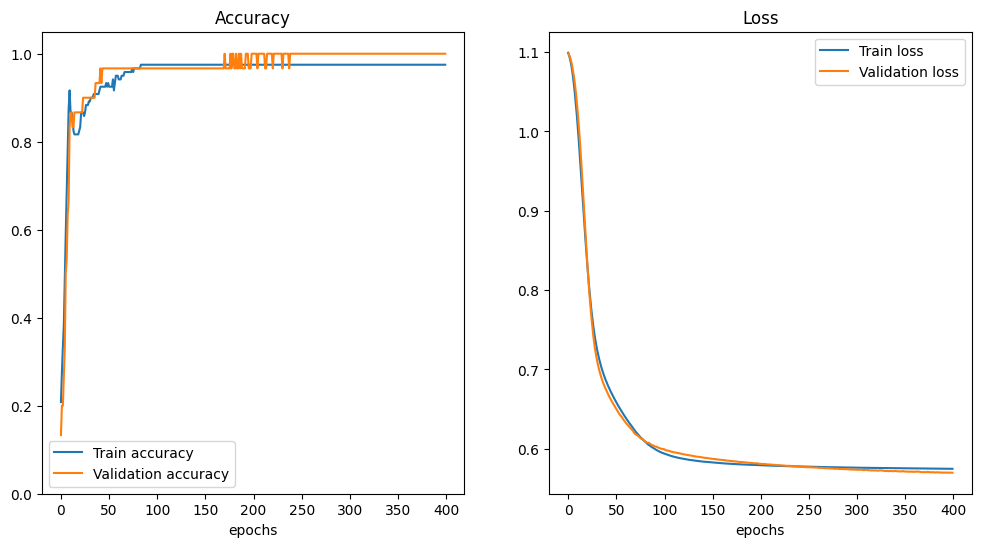


✅ All 15 runs saved in one file → results\ClassicalModel_layers[2, 2]_epochs400_15runs_20251202_182413.csv
🚀 Run 1/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:09<00:00, 40.09it/s]


🏁 Validation accuracy (run 1): 1.000
⏱️ Epochs to converge (train/valid) ≈ 148/177
🚀 Run 2/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:10<00:00, 37.71it/s]


🏁 Validation accuracy (run 2): 0.967
⏱️ Epochs to converge (train/valid) ≈ 165/215
🚀 Run 3/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:10<00:00, 39.68it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 175/120
🚀 Run 4/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:09<00:00, 41.51it/s]


🏁 Validation accuracy (run 4): 1.000
⏱️ Epochs to converge (train/valid) ≈ 120/158
🚀 Run 5/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:08<00:00, 49.67it/s]


🏁 Validation accuracy (run 5): 0.967
⏱️ Epochs to converge (train/valid) ≈ 142/127
🚀 Run 6/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:08<00:00, 49.35it/s]


🏁 Validation accuracy (run 6): 0.967
⏱️ Epochs to converge (train/valid) ≈ 128/122
🚀 Run 7/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:08<00:00, 49.21it/s]


🏁 Validation accuracy (run 7): 0.933
⏱️ Epochs to converge (train/valid) ≈ 163/104
🚀 Run 8/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:08<00:00, 47.66it/s]


🏁 Validation accuracy (run 8): 0.967
⏱️ Epochs to converge (train/valid) ≈ 163/138
🚀 Run 9/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:07<00:00, 51.65it/s]


🏁 Validation accuracy (run 9): 1.000
⏱️ Epochs to converge (train/valid) ≈ 142/142
🚀 Run 10/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:10<00:00, 39.80it/s]


🏁 Validation accuracy (run 10): 0.967
⏱️ Epochs to converge (train/valid) ≈ 175/114
🚀 Run 11/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:08<00:00, 47.50it/s]


🏁 Validation accuracy (run 11): 0.967
⏱️ Epochs to converge (train/valid) ≈ 113/126
🚀 Run 12/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:07<00:00, 51.74it/s]


🏁 Validation accuracy (run 12): 0.967
⏱️ Epochs to converge (train/valid) ≈ 149/99
🚀 Run 13/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:07<00:00, 51.58it/s]


🏁 Validation accuracy (run 13): 1.000
⏱️ Epochs to converge (train/valid) ≈ 158/216
🚀 Run 14/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:09<00:00, 40.64it/s]


🏁 Validation accuracy (run 14): 0.933
⏱️ Epochs to converge (train/valid) ≈ 187/94
🚀 Run 15/15 for ClassicalModel with layers [2, 2, 2]


100%|██████████| 400/400 [00:09<00:00, 42.39it/s]


🏁 Validation accuracy (run 15): 0.967
⏱️ Epochs to converge (train/valid) ≈ 172/143


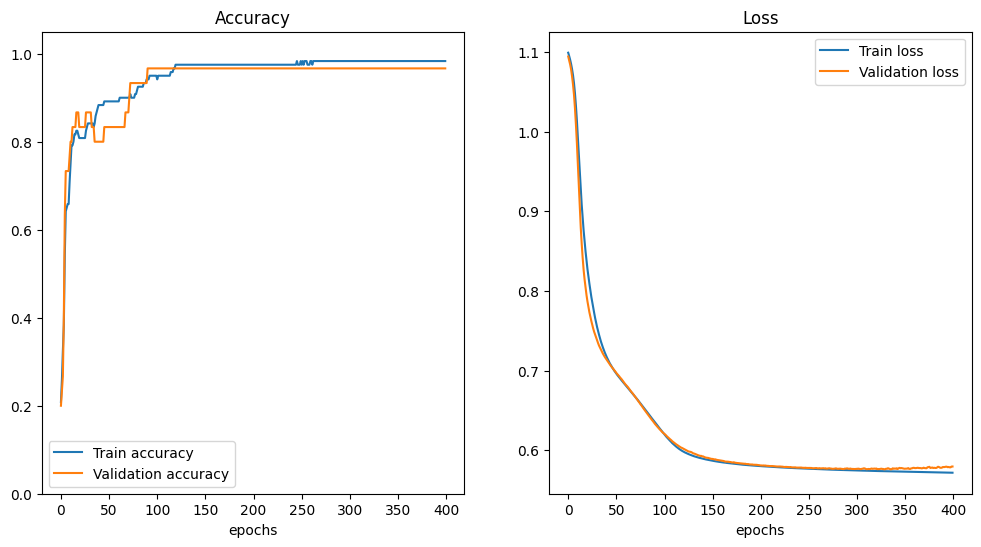


✅ All 15 runs saved in one file → results\ClassicalModel_layers[2, 2, 2]_epochs400_15runs_20251202_182634.csv
🚀 Run 1/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:08<00:00, 46.15it/s]


🏁 Validation accuracy (run 1): 0.933
⏱️ Epochs to converge (train/valid) ≈ 175/114
🚀 Run 2/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:08<00:00, 48.26it/s]


🏁 Validation accuracy (run 2): 0.933
⏱️ Epochs to converge (train/valid) ≈ 191/137
🚀 Run 3/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:08<00:00, 45.62it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 191/114
🚀 Run 4/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:08<00:00, 49.42it/s]


🏁 Validation accuracy (run 4): 0.933
⏱️ Epochs to converge (train/valid) ≈ 164/101
🚀 Run 5/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:09<00:00, 43.54it/s]


🏁 Validation accuracy (run 5): 1.000
⏱️ Epochs to converge (train/valid) ≈ 117/151
🚀 Run 6/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:08<00:00, 46.44it/s]


🏁 Validation accuracy (run 6): 0.933
⏱️ Epochs to converge (train/valid) ≈ 166/123
🚀 Run 7/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:09<00:00, 41.01it/s]


🏁 Validation accuracy (run 7): 0.967
⏱️ Epochs to converge (train/valid) ≈ 132/97
🚀 Run 8/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:09<00:00, 40.42it/s]


🏁 Validation accuracy (run 8): 1.000
⏱️ Epochs to converge (train/valid) ≈ 124/150
🚀 Run 9/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:11<00:00, 35.99it/s]


🏁 Validation accuracy (run 9): 0.933
⏱️ Epochs to converge (train/valid) ≈ 174/115
🚀 Run 10/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:09<00:00, 42.20it/s]


🏁 Validation accuracy (run 10): 0.967
⏱️ Epochs to converge (train/valid) ≈ 150/124
🚀 Run 11/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:09<00:00, 43.60it/s]


🏁 Validation accuracy (run 11): 0.967
⏱️ Epochs to converge (train/valid) ≈ 155/96
🚀 Run 12/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:08<00:00, 45.34it/s]


🏁 Validation accuracy (run 12): 1.000
⏱️ Epochs to converge (train/valid) ≈ 86/112
🚀 Run 13/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:09<00:00, 43.72it/s]


🏁 Validation accuracy (run 13): 0.967
⏱️ Epochs to converge (train/valid) ≈ 187/142
🚀 Run 14/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:09<00:00, 43.54it/s]


🏁 Validation accuracy (run 14): 0.967
⏱️ Epochs to converge (train/valid) ≈ 120/91
🚀 Run 15/15 for ClassicalModel with layers [2, 2, 2, 2]


100%|██████████| 400/400 [00:11<00:00, 33.97it/s]


🏁 Validation accuracy (run 15): 0.967
⏱️ Epochs to converge (train/valid) ≈ 204/151


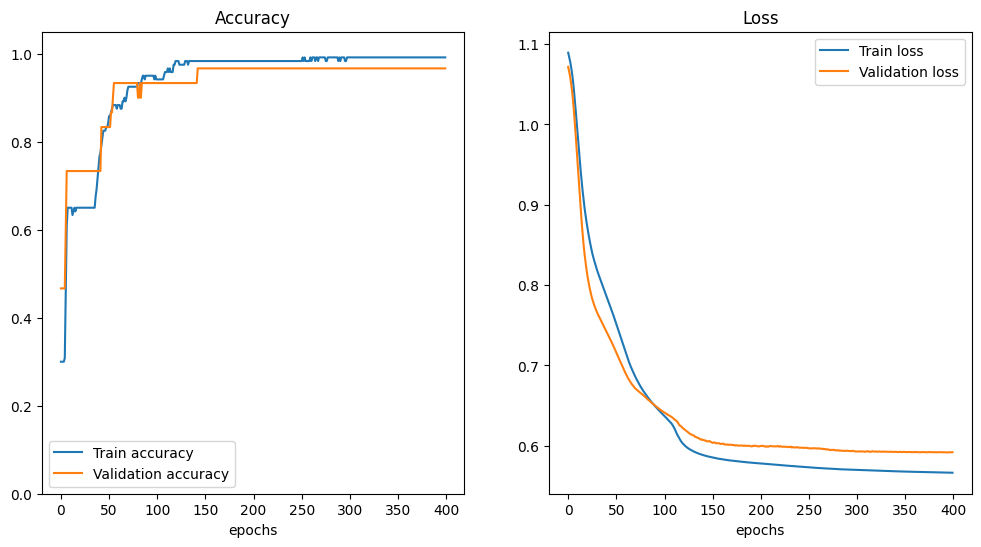


✅ All 15 runs saved in one file → results\ClassicalModel_layers[2, 2, 2, 2]_epochs400_15runs_20251202_182849.csv
🚀 Run 1/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:13<00:00, 29.02it/s]


🏁 Validation accuracy (run 1): 0.967
⏱️ Epochs to converge (train/valid) ≈ 156/159
🚀 Run 2/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:09<00:00, 43.28it/s]


🏁 Validation accuracy (run 2): 0.967
⏱️ Epochs to converge (train/valid) ≈ 172/184
🚀 Run 3/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 66.02it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 159/106
🚀 Run 4/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 63.46it/s]


🏁 Validation accuracy (run 4): 1.000
⏱️ Epochs to converge (train/valid) ≈ 130/176
🚀 Run 5/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 66.03it/s]


🏁 Validation accuracy (run 5): 1.000
⏱️ Epochs to converge (train/valid) ≈ 102/244
🚀 Run 6/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 65.74it/s]


🏁 Validation accuracy (run 6): 1.000
⏱️ Epochs to converge (train/valid) ≈ 132/165
🚀 Run 7/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 65.06it/s]


🏁 Validation accuracy (run 7): 0.933
⏱️ Epochs to converge (train/valid) ≈ 164/106
🚀 Run 8/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 61.00it/s]


🏁 Validation accuracy (run 8): 0.967
⏱️ Epochs to converge (train/valid) ≈ 158/90
🚀 Run 9/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 63.73it/s]


🏁 Validation accuracy (run 9): 0.933
⏱️ Epochs to converge (train/valid) ≈ 140/91
🚀 Run 10/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 65.55it/s]


🏁 Validation accuracy (run 10): 0.967
⏱️ Epochs to converge (train/valid) ≈ 145/89
🚀 Run 11/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 66.17it/s]


🏁 Validation accuracy (run 11): 0.967
⏱️ Epochs to converge (train/valid) ≈ 287/263
🚀 Run 12/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 64.58it/s]


🏁 Validation accuracy (run 12): 1.000
⏱️ Epochs to converge (train/valid) ≈ 114/166
🚀 Run 13/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 66.37it/s]


🏁 Validation accuracy (run 13): 0.933
⏱️ Epochs to converge (train/valid) ≈ 157/84
🚀 Run 14/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 64.64it/s]


🏁 Validation accuracy (run 14): 0.933
⏱️ Epochs to converge (train/valid) ≈ 165/97
🚀 Run 15/15 for ClassicalModel with layers [3]


100%|██████████| 400/400 [00:06<00:00, 65.96it/s]


🏁 Validation accuracy (run 15): 1.000
⏱️ Epochs to converge (train/valid) ≈ 144/206


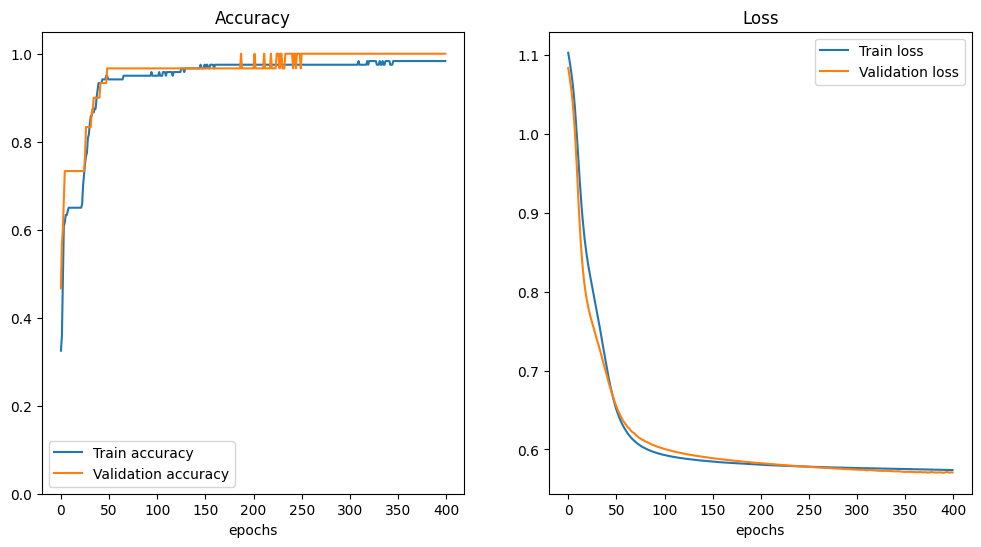


✅ All 15 runs saved in one file → results\ClassicalModel_layers[3]_epochs400_15runs_20251202_183109.csv
🚀 Run 1/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:06<00:00, 66.00it/s]


🏁 Validation accuracy (run 1): 1.000
⏱️ Epochs to converge (train/valid) ≈ 129/157
🚀 Run 2/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:05<00:00, 67.18it/s]


🏁 Validation accuracy (run 2): 0.967
⏱️ Epochs to converge (train/valid) ≈ 153/141
🚀 Run 3/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:05<00:00, 68.02it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 153/116
🚀 Run 4/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:06<00:00, 64.53it/s]


🏁 Validation accuracy (run 4): 0.933
⏱️ Epochs to converge (train/valid) ≈ 161/157
🚀 Run 5/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:06<00:00, 65.98it/s]


🏁 Validation accuracy (run 5): 0.967
⏱️ Epochs to converge (train/valid) ≈ 206/123
🚀 Run 6/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:06<00:00, 64.50it/s]


🏁 Validation accuracy (run 6): 0.967
⏱️ Epochs to converge (train/valid) ≈ 140/90
🚀 Run 7/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:07<00:00, 56.35it/s]


🏁 Validation accuracy (run 7): 0.967
⏱️ Epochs to converge (train/valid) ≈ 184/118
🚀 Run 8/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:06<00:00, 63.80it/s]


🏁 Validation accuracy (run 8): 0.933
⏱️ Epochs to converge (train/valid) ≈ 168/89
🚀 Run 9/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:06<00:00, 60.64it/s]


🏁 Validation accuracy (run 9): 0.967
⏱️ Epochs to converge (train/valid) ≈ 133/89
🚀 Run 10/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:06<00:00, 62.37it/s]


🏁 Validation accuracy (run 10): 0.933
⏱️ Epochs to converge (train/valid) ≈ 141/121
🚀 Run 11/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:06<00:00, 61.42it/s]


🏁 Validation accuracy (run 11): 0.967
⏱️ Epochs to converge (train/valid) ≈ 153/179
🚀 Run 12/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:06<00:00, 62.51it/s]


🏁 Validation accuracy (run 12): 0.967
⏱️ Epochs to converge (train/valid) ≈ 148/111
🚀 Run 13/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:06<00:00, 59.93it/s]


🏁 Validation accuracy (run 13): 0.967
⏱️ Epochs to converge (train/valid) ≈ 135/112
🚀 Run 14/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:06<00:00, 60.07it/s]


🏁 Validation accuracy (run 14): 0.967
⏱️ Epochs to converge (train/valid) ≈ 157/132
🚀 Run 15/15 for ClassicalModel with layers [3, 3]


100%|██████████| 400/400 [00:06<00:00, 57.76it/s]


🏁 Validation accuracy (run 15): 0.933
⏱️ Epochs to converge (train/valid) ≈ 189/121


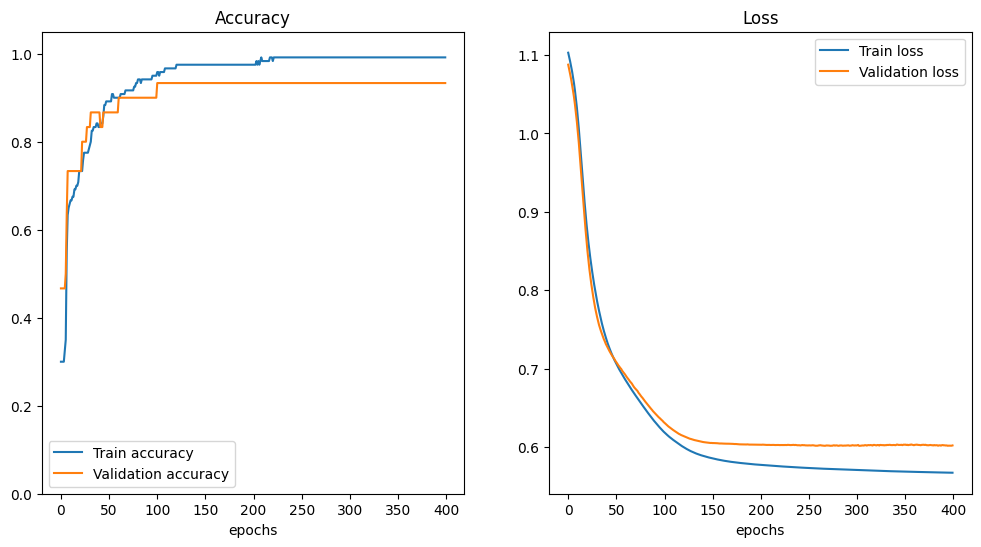


✅ All 15 runs saved in one file → results\ClassicalModel_layers[3, 3]_epochs400_15runs_20251202_183253.csv
🚀 Run 1/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 60.29it/s]


🏁 Validation accuracy (run 1): 0.967
⏱️ Epochs to converge (train/valid) ≈ 155/104
🚀 Run 2/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 61.77it/s]


🏁 Validation accuracy (run 2): 0.933
⏱️ Epochs to converge (train/valid) ≈ 180/141
🚀 Run 3/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 60.10it/s]


🏁 Validation accuracy (run 3): 1.000
⏱️ Epochs to converge (train/valid) ≈ 115/187
🚀 Run 4/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 62.43it/s]


🏁 Validation accuracy (run 4): 0.967
⏱️ Epochs to converge (train/valid) ≈ 131/102
🚀 Run 5/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 60.80it/s]


🏁 Validation accuracy (run 5): 0.933
⏱️ Epochs to converge (train/valid) ≈ 160/81
🚀 Run 6/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 61.82it/s]


🏁 Validation accuracy (run 6): 0.933
⏱️ Epochs to converge (train/valid) ≈ 158/93
🚀 Run 7/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 60.14it/s]


🏁 Validation accuracy (run 7): 1.000
⏱️ Epochs to converge (train/valid) ≈ 133/168
🚀 Run 8/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 62.22it/s]


🏁 Validation accuracy (run 8): 0.933
⏱️ Epochs to converge (train/valid) ≈ 165/131
🚀 Run 9/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 61.94it/s]


🏁 Validation accuracy (run 9): 0.933
⏱️ Epochs to converge (train/valid) ≈ 148/85
🚀 Run 10/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:07<00:00, 55.15it/s]


🏁 Validation accuracy (run 10): 0.967
⏱️ Epochs to converge (train/valid) ≈ 155/104
🚀 Run 11/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 61.62it/s]


🏁 Validation accuracy (run 11): 0.967
⏱️ Epochs to converge (train/valid) ≈ 162/89
🚀 Run 12/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 59.92it/s]


🏁 Validation accuracy (run 12): 0.967
⏱️ Epochs to converge (train/valid) ≈ 117/133
🚀 Run 13/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 62.52it/s]


🏁 Validation accuracy (run 13): 0.933
⏱️ Epochs to converge (train/valid) ≈ 149/108
🚀 Run 14/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 62.13it/s]


🏁 Validation accuracy (run 14): 0.967
⏱️ Epochs to converge (train/valid) ≈ 168/179
🚀 Run 15/15 for ClassicalModel with layers [3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 62.09it/s]


🏁 Validation accuracy (run 15): 0.967
⏱️ Epochs to converge (train/valid) ≈ 141/92


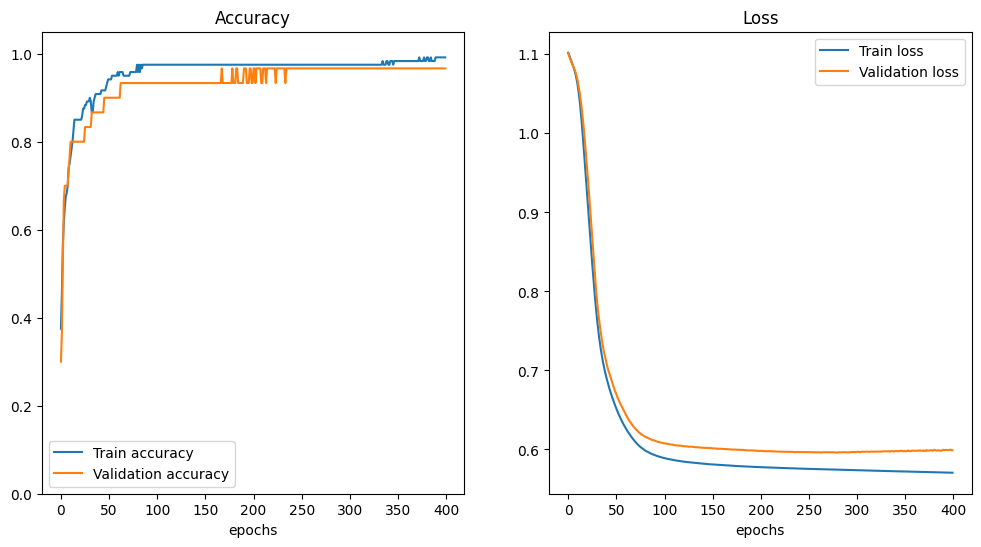


✅ All 15 runs saved in one file → results\ClassicalModel_layers[3, 3, 3]_epochs400_15runs_20251202_183429.csv
🚀 Run 1/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 63.10it/s]


🏁 Validation accuracy (run 1): 0.933
⏱️ Epochs to converge (train/valid) ≈ 159/103
🚀 Run 2/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 60.67it/s]


🏁 Validation accuracy (run 2): 1.000
⏱️ Epochs to converge (train/valid) ≈ 107/128
🚀 Run 3/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 64.21it/s]


🏁 Validation accuracy (run 3): 0.933
⏱️ Epochs to converge (train/valid) ≈ 163/85
🚀 Run 4/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:07<00:00, 54.21it/s]


🏁 Validation accuracy (run 4): 0.967
⏱️ Epochs to converge (train/valid) ≈ 163/148
🚀 Run 5/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 59.99it/s]


🏁 Validation accuracy (run 5): 0.933
⏱️ Epochs to converge (train/valid) ≈ 178/154
🚀 Run 6/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 63.98it/s]


🏁 Validation accuracy (run 6): 0.933
⏱️ Epochs to converge (train/valid) ≈ 197/140
🚀 Run 7/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 64.88it/s]


🏁 Validation accuracy (run 7): 0.933
⏱️ Epochs to converge (train/valid) ≈ 186/91
🚀 Run 8/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 65.64it/s]


🏁 Validation accuracy (run 8): 0.933
⏱️ Epochs to converge (train/valid) ≈ 131/81
🚀 Run 9/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 60.26it/s]


🏁 Validation accuracy (run 9): 0.967
⏱️ Epochs to converge (train/valid) ≈ 110/149
🚀 Run 10/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 66.35it/s]


🏁 Validation accuracy (run 10): 0.967
⏱️ Epochs to converge (train/valid) ≈ 123/88
🚀 Run 11/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 65.57it/s]


🏁 Validation accuracy (run 11): 0.933
⏱️ Epochs to converge (train/valid) ≈ 171/180
🚀 Run 12/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:05<00:00, 67.03it/s]


🏁 Validation accuracy (run 12): 0.933
⏱️ Epochs to converge (train/valid) ≈ 186/65
🚀 Run 13/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:05<00:00, 67.33it/s]


🏁 Validation accuracy (run 13): 1.000
⏱️ Epochs to converge (train/valid) ≈ 116/151
🚀 Run 14/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 61.06it/s]


🏁 Validation accuracy (run 14): 0.967
⏱️ Epochs to converge (train/valid) ≈ 161/128
🚀 Run 15/15 for ClassicalModel with layers [3, 3, 3, 3]


100%|██████████| 400/400 [00:06<00:00, 62.57it/s]


🏁 Validation accuracy (run 15): 0.967
⏱️ Epochs to converge (train/valid) ≈ 131/88


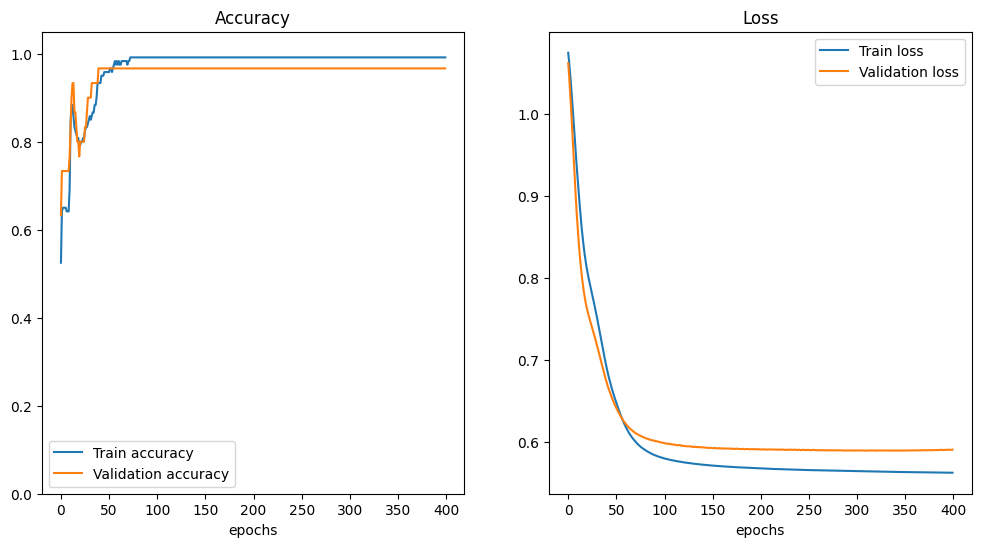


✅ All 15 runs saved in one file → results\ClassicalModel_layers[3, 3, 3, 3]_epochs400_15runs_20251202_183608.csv
🚀 Run 1/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 66.30it/s]


🏁 Validation accuracy (run 1): 0.967
⏱️ Epochs to converge (train/valid) ≈ 165/195
🚀 Run 2/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:05<00:00, 67.47it/s]


🏁 Validation accuracy (run 2): 0.967
⏱️ Epochs to converge (train/valid) ≈ 113/108
🚀 Run 3/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 66.63it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 160/119
🚀 Run 4/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 65.05it/s]


🏁 Validation accuracy (run 4): 0.967
⏱️ Epochs to converge (train/valid) ≈ 150/91
🚀 Run 5/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 63.47it/s]


🏁 Validation accuracy (run 5): 0.967
⏱️ Epochs to converge (train/valid) ≈ 175/124
🚀 Run 6/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 65.28it/s]


🏁 Validation accuracy (run 6): 0.967
⏱️ Epochs to converge (train/valid) ≈ 172/158
🚀 Run 7/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 64.35it/s]


🏁 Validation accuracy (run 7): 0.967
⏱️ Epochs to converge (train/valid) ≈ 130/145
🚀 Run 8/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 57.70it/s]


🏁 Validation accuracy (run 8): 0.967
⏱️ Epochs to converge (train/valid) ≈ 285/212
🚀 Run 9/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 60.99it/s]


🏁 Validation accuracy (run 9): 0.933
⏱️ Epochs to converge (train/valid) ≈ 178/141
🚀 Run 10/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 61.64it/s]


🏁 Validation accuracy (run 10): 0.967
⏱️ Epochs to converge (train/valid) ≈ 169/154
🚀 Run 11/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 61.15it/s]


🏁 Validation accuracy (run 11): 0.933
⏱️ Epochs to converge (train/valid) ≈ 279/212
🚀 Run 12/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 63.25it/s]


🏁 Validation accuracy (run 12): 0.967
⏱️ Epochs to converge (train/valid) ≈ 157/102
🚀 Run 13/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 62.81it/s]


🏁 Validation accuracy (run 13): 1.000
⏱️ Epochs to converge (train/valid) ≈ 111/136
🚀 Run 14/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 63.29it/s]


🏁 Validation accuracy (run 14): 0.967
⏱️ Epochs to converge (train/valid) ≈ 125/147
🚀 Run 15/15 for ClassicalModel with layers [4]


100%|██████████| 400/400 [00:06<00:00, 62.02it/s]


🏁 Validation accuracy (run 15): 0.967
⏱️ Epochs to converge (train/valid) ≈ 170/162


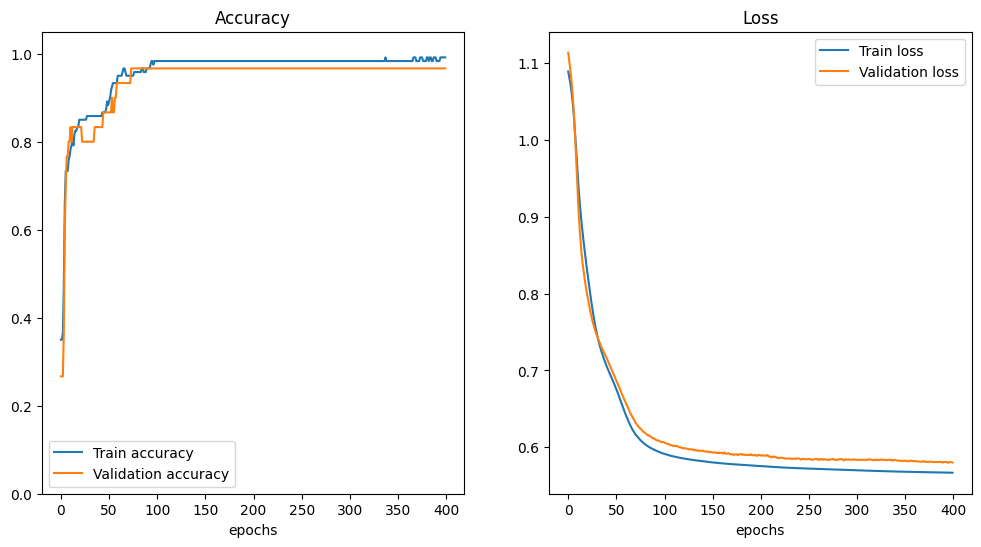


✅ All 15 runs saved in one file → results\ClassicalModel_layers[4]_epochs400_15runs_20251202_183744.csv
🚀 Run 1/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 64.25it/s]


🏁 Validation accuracy (run 1): 0.967
⏱️ Epochs to converge (train/valid) ≈ 159/139
🚀 Run 2/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 58.08it/s]


🏁 Validation accuracy (run 2): 1.000
⏱️ Epochs to converge (train/valid) ≈ 127/185
🚀 Run 3/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 64.20it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 154/89
🚀 Run 4/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 64.69it/s]


🏁 Validation accuracy (run 4): 0.933
⏱️ Epochs to converge (train/valid) ≈ 186/131
🚀 Run 5/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 61.55it/s]


🏁 Validation accuracy (run 5): 0.967
⏱️ Epochs to converge (train/valid) ≈ 158/106
🚀 Run 6/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 63.36it/s]


🏁 Validation accuracy (run 6): 0.967
⏱️ Epochs to converge (train/valid) ≈ 241/144
🚀 Run 7/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 62.83it/s]


🏁 Validation accuracy (run 7): 0.967
⏱️ Epochs to converge (train/valid) ≈ 146/154
🚀 Run 8/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 62.95it/s]


🏁 Validation accuracy (run 8): 0.967
⏱️ Epochs to converge (train/valid) ≈ 125/164
🚀 Run 9/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 60.70it/s]


🏁 Validation accuracy (run 9): 0.933
⏱️ Epochs to converge (train/valid) ≈ 148/73
🚀 Run 10/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 63.74it/s]


🏁 Validation accuracy (run 10): 0.933
⏱️ Epochs to converge (train/valid) ≈ 134/93
🚀 Run 11/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 63.29it/s]


🏁 Validation accuracy (run 11): 0.967
⏱️ Epochs to converge (train/valid) ≈ 274/311
🚀 Run 12/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 63.09it/s]


🏁 Validation accuracy (run 12): 0.933
⏱️ Epochs to converge (train/valid) ≈ 178/75
🚀 Run 13/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:08<00:00, 49.48it/s]


🏁 Validation accuracy (run 13): 1.000
⏱️ Epochs to converge (train/valid) ≈ 129/243
🚀 Run 14/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:08<00:00, 46.41it/s]


🏁 Validation accuracy (run 14): 0.967
⏱️ Epochs to converge (train/valid) ≈ 173/132
🚀 Run 15/15 for ClassicalModel with layers [4, 4]


100%|██████████| 400/400 [00:06<00:00, 58.03it/s]


🏁 Validation accuracy (run 15): 1.000
⏱️ Epochs to converge (train/valid) ≈ 133/177


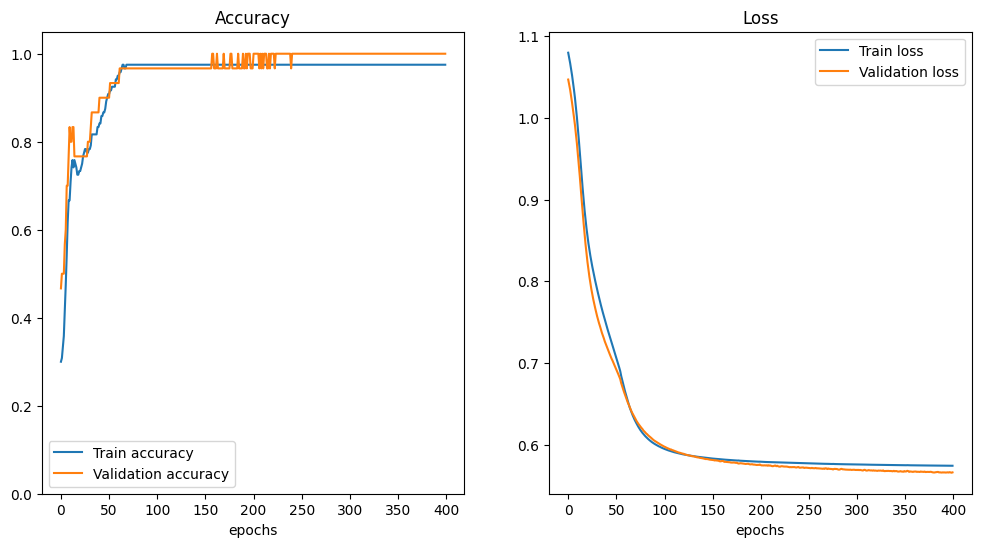


✅ All 15 runs saved in one file → results\ClassicalModel_layers[4, 4]_epochs400_15runs_20251202_183919.csv
🚀 Run 1/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 63.48it/s]


🏁 Validation accuracy (run 1): 0.933
⏱️ Epochs to converge (train/valid) ≈ 126/124
🚀 Run 2/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 57.31it/s]


🏁 Validation accuracy (run 2): 0.967
⏱️ Epochs to converge (train/valid) ≈ 152/100
🚀 Run 3/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:09<00:00, 42.41it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 127/157
🚀 Run 4/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:09<00:00, 41.04it/s]


🏁 Validation accuracy (run 4): 0.967
⏱️ Epochs to converge (train/valid) ≈ 211/140
🚀 Run 5/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:07<00:00, 53.32it/s]


🏁 Validation accuracy (run 5): 0.933
⏱️ Epochs to converge (train/valid) ≈ 174/109
🚀 Run 6/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:09<00:00, 42.65it/s]


🏁 Validation accuracy (run 6): 0.967
⏱️ Epochs to converge (train/valid) ≈ 183/115
🚀 Run 7/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:07<00:00, 53.64it/s]


🏁 Validation accuracy (run 7): 0.967
⏱️ Epochs to converge (train/valid) ≈ 181/122
🚀 Run 8/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 60.91it/s]


🏁 Validation accuracy (run 8): 0.933
⏱️ Epochs to converge (train/valid) ≈ 151/80
🚀 Run 9/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 59.86it/s]


🏁 Validation accuracy (run 9): 0.967
⏱️ Epochs to converge (train/valid) ≈ 176/144
🚀 Run 10/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 61.34it/s]


🏁 Validation accuracy (run 10): 0.933
⏱️ Epochs to converge (train/valid) ≈ 150/81
🚀 Run 11/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:07<00:00, 54.60it/s]


🏁 Validation accuracy (run 11): 1.000
⏱️ Epochs to converge (train/valid) ≈ 127/173
🚀 Run 12/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 60.06it/s]


🏁 Validation accuracy (run 12): 0.967
⏱️ Epochs to converge (train/valid) ≈ 112/135
🚀 Run 13/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 57.61it/s]


🏁 Validation accuracy (run 13): 1.000
⏱️ Epochs to converge (train/valid) ≈ 132/208
🚀 Run 14/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 59.83it/s]


🏁 Validation accuracy (run 14): 0.933
⏱️ Epochs to converge (train/valid) ≈ 162/95
🚀 Run 15/15 for ClassicalModel with layers [4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 57.66it/s]


🏁 Validation accuracy (run 15): 0.967
⏱️ Epochs to converge (train/valid) ≈ 177/139


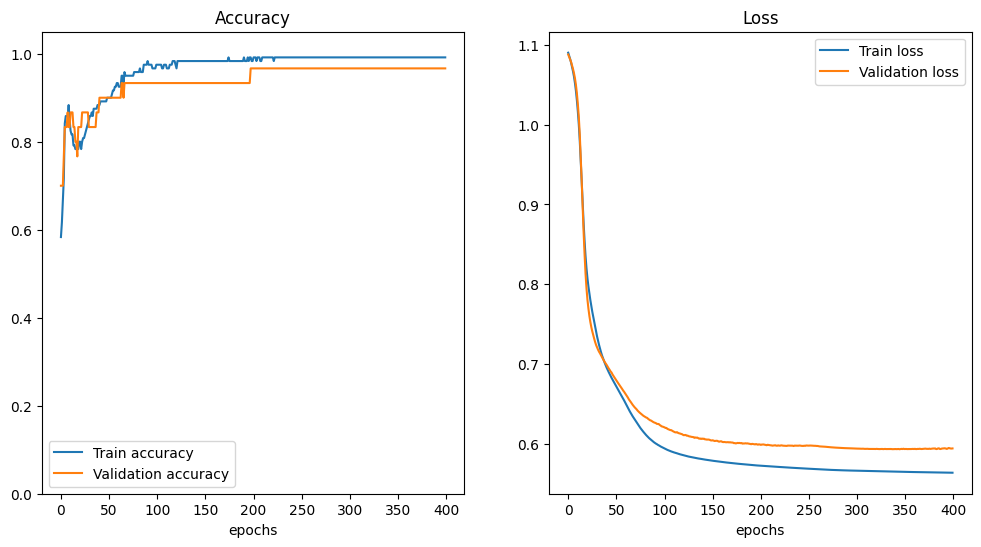


✅ All 15 runs saved in one file → results\ClassicalModel_layers[4, 4, 4]_epochs400_15runs_20251202_184059.csv
🚀 Run 1/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 61.34it/s]


🏁 Validation accuracy (run 1): 0.967
⏱️ Epochs to converge (train/valid) ≈ 147/196
🚀 Run 2/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 61.69it/s]


🏁 Validation accuracy (run 2): 0.967
⏱️ Epochs to converge (train/valid) ≈ 170/123
🚀 Run 3/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 59.59it/s]


🏁 Validation accuracy (run 3): 0.967
⏱️ Epochs to converge (train/valid) ≈ 159/94
🚀 Run 4/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:07<00:00, 53.34it/s]


🏁 Validation accuracy (run 4): 0.967
⏱️ Epochs to converge (train/valid) ≈ 148/82
🚀 Run 5/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:07<00:00, 53.22it/s]


🏁 Validation accuracy (run 5): 0.967
⏱️ Epochs to converge (train/valid) ≈ 149/132
🚀 Run 6/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:07<00:00, 55.09it/s]


🏁 Validation accuracy (run 6): 0.967
⏱️ Epochs to converge (train/valid) ≈ 147/86
🚀 Run 7/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 57.66it/s]


🏁 Validation accuracy (run 7): 0.933
⏱️ Epochs to converge (train/valid) ≈ 159/120
🚀 Run 8/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:07<00:00, 55.11it/s]


🏁 Validation accuracy (run 8): 0.967
⏱️ Epochs to converge (train/valid) ≈ 154/128
🚀 Run 9/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 60.21it/s]


🏁 Validation accuracy (run 9): 0.933
⏱️ Epochs to converge (train/valid) ≈ 164/93
🚀 Run 10/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 58.20it/s]


🏁 Validation accuracy (run 10): 1.000
⏱️ Epochs to converge (train/valid) ≈ 110/149
🚀 Run 11/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 60.22it/s]


🏁 Validation accuracy (run 11): 0.933
⏱️ Epochs to converge (train/valid) ≈ 206/132
🚀 Run 12/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:07<00:00, 54.99it/s]


🏁 Validation accuracy (run 12): 0.933
⏱️ Epochs to converge (train/valid) ≈ 155/79
🚀 Run 13/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:07<00:00, 51.21it/s]


🏁 Validation accuracy (run 13): 0.967
⏱️ Epochs to converge (train/valid) ≈ 136/72
🚀 Run 14/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 58.03it/s]


🏁 Validation accuracy (run 14): 0.967
⏱️ Epochs to converge (train/valid) ≈ 135/122
🚀 Run 15/15 for ClassicalModel with layers [4, 4, 4, 4]


100%|██████████| 400/400 [00:06<00:00, 59.02it/s]


🏁 Validation accuracy (run 15): 0.933
⏱️ Epochs to converge (train/valid) ≈ 286/182


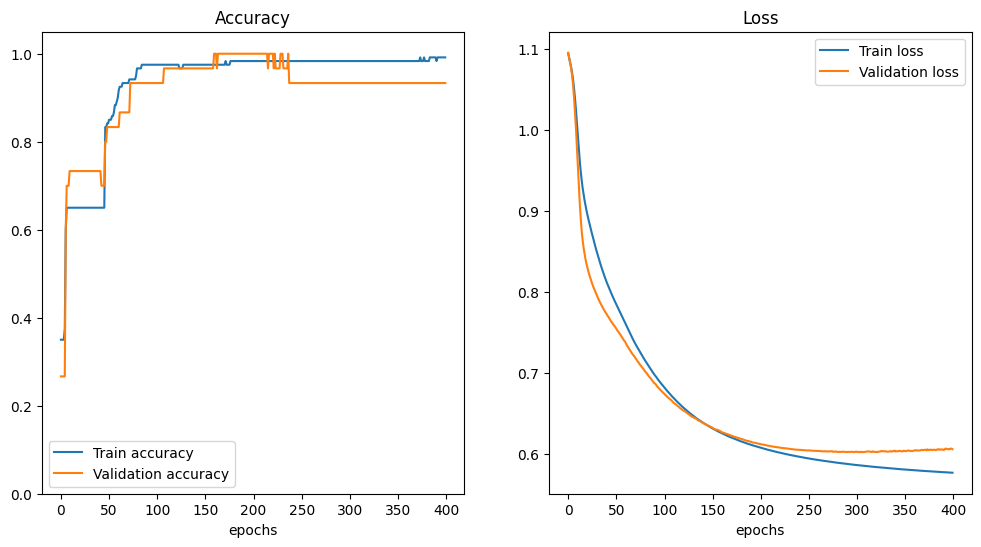


✅ All 15 runs saved in one file → results\ClassicalModel_layers[4, 4, 4, 4]_epochs400_15runs_20251202_184251.csv


In [ ]:
a = train_backprop()

for n in range(1, 5):  # neurons per layer 1 → 4
    for layers in range(1, 5):  # number of layers 1 → 4

        hidden_config = [n] * layers  # e.g. [3,3,3]

        # run training + save CSV
        a.graph_train_IRIS(ClassicalModel_ReLU_NoBias(hidden_sizes=hidden_config))